In [ ]:
%pip install lightning torchmetrics timm --quiet

In [ ]:
import os
import numpy as np
from PIL import Image
import random

import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchmetrics as tm
import timm

%matplotlib inline

In [ ]:
DATASET_PATH = './data/cifar10'
CHECKPOINT_PATH = './experiments/'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])
test_set = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=1)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=1)

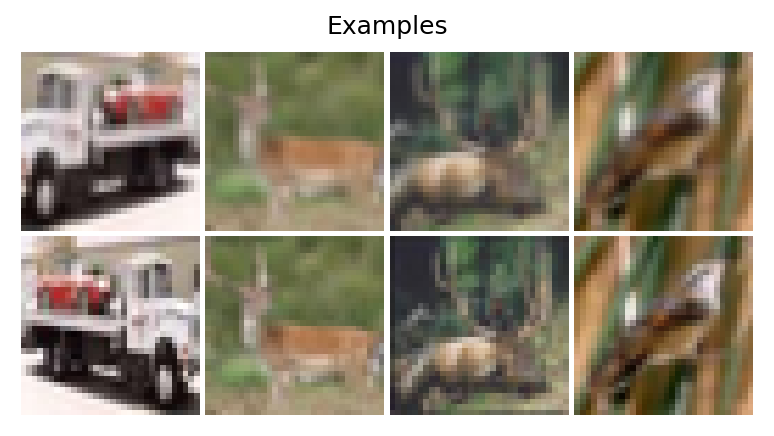

In [ ]:
NUM_IMAGES = 4
idxs = random.sample(range(len(train_dataset)), NUM_IMAGES)
images = [train_dataset[idx][0] for idx in idxs]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in idxs]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, pad_value=1, padding=1)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(dpi=150)
plt.title("Examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [ ]:
class CenterLoss(nn.Module):
    """Center loss.

    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t() \
                  - 2 * x @ self.centers.t()

        classes = torch.arange(self.num_classes, device=labels.device, dtype=torch.long)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [ ]:
class ClassificationModule(L.LightningModule):
    def __init__(self, num_classes, model_name='mobilenetv3_large_100', pretrained=True):
        super().__init__()
        self.save_hyperparameters()

        self.feature_extractor = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        embedding_dim = 1280
        self.classifier = nn.Linear(embedding_dim, num_classes)

        self.example_input_array = torch.zeros((1, 3, 224, 224), dtype=torch.float32)

        fe_cfg = self.feature_extractor.pretrained_cfg if pretrained else self.feature_extractor.default_cfg
        self.register_buffer('mean', torch.tensor(fe_cfg["mean"]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor(fe_cfg["std"]).view(1, 3, 1, 1))

        self.cross_entropy_loss = nn.CrossEntropyLoss()

        feat_dim = 2
        self.mapping = nn.Linear(embedding_dim, feat_dim)
        self.center_loss = CenterLoss(num_classes, feat_dim)

        self.accuracy = {
            'val': tm.Accuracy(task="multiclass", num_classes=num_classes),
            'test': tm.Accuracy(task="multiclass", num_classes=num_classes),
        }

    def forward(self, img):
        img = (img - self.mean) / self.std
        embedding = self.feature_extractor(img)
        logits = self.classifier(embedding)
        return embedding, logits

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=3e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embedding, logits = self(imgs)

        cross_entropy_loss = self.cross_entropy_loss(logits, labels)
        center_loss = self.center_loss(self.mapping(embedding), labels)
        total_loss = cross_entropy_loss + 0.1 * center_loss

        self.log("cross_entropy_loss", total_loss, prog_bar=True, logger=True)
        self.log("center_loss", total_loss, prog_bar=True, logger=True)
        self.log("total_loss", total_loss, prog_bar=True, logger=True)

        return total_loss

    def eval_step(self, batch, batch_idx, stage):
        imgs, labels = batch
        embedding, logits = self(imgs)
        preds = logits.argmax(dim=-1)
        self.accuracy[stage].update(preds.cpu(), labels.cpu())

    def on_eval_epoch_end(self, stage, **kwargs):
        self.log(f"{stage}_acc", self.accuracy[stage].compute(), prog_bar=True, logger=True)
        self.accuracy[stage].reset()

    def validation_step(self, batch, batch_idx):
        self.eval_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        self.eval_step(batch, batch_idx, 'test')

    def on_validation_epoch_end(self, **kwargs):
        self.on_eval_epoch_end('val', **kwargs)

    def on_test_epoch_end(self, **kwargs):
        self.on_eval_epoch_end('test', **kwargs)

In [ ]:
def train_model(experiment_name, **model_kwargs):

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, experiment_name),
        accelerator='gpu' if str(device) == "cuda:0" else 'cpu',
        devices=1,
        max_epochs=10,
        callbacks=[
            L.pytorch.callbacks.ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            L.pytorch.callbacks.progress.TQDMProgressBar(refresh_rate=5),
        ],
    )

    pretrained_filename = os.path.join(CHECKPOINT_PATH, experiment_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ClassificationModule.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42, workers=True)
        model = ClassificationModule(**model_kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ClassificationModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        print(f"Loading checkpoint from best_model_path: {trainer.checkpoint_callback.best_model_path}")

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"val": val_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [ ]:
model, result = train_model('my_experiment_1', num_classes=10)
result

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authenticat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading checkpoint from best_model_path: experiments/my_experiment_1/lightning_logs/version_1/checkpoints/epoch=9-step=3510.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'val': 0.7993999719619751, 'test': 0.7915999889373779}